In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='\nDate', ylabel='Settle'>

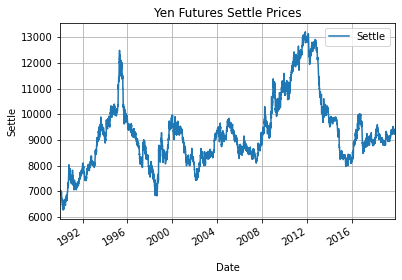

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(
    xlabel = "\nDate", 
    ylabel = "Settle", 
    xlim = ["1990-01-02", "2019-10-15"],
    legend = True,
    grid = True,
    title = "Yen Futures Settle Prices"
)

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

ts_noise_df = pd.DataFrame(ts_noise)
ts_trend_df = pd.DataFrame(ts_trend)

ts_noise_df.head()

,Settle_cycle
Date,
1990-01-02,-61.503967
1990-01-03,-21.799756
1990-01-04,98.942896
1990-01-05,40.776052
1990-01-08,49.689938


In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_futures_settle_df = yen_futures["Settle"]

# Connecting 3 data frames into one
yen_futures_settle_all_df = pd.concat([yen_futures_settle_df, 
                                       ts_noise_df, ts_trend_df],
                                      axis="columns", join="inner")

# Renaming the columns
yen_futures_settle_all_df.rename(columns = {"Settle_cycle": "Noise",
                                            "Settle_trend": "Trend" },
                                 inplace = True)  

# Viewing the preliminary form of the dataframe
yen_futures_settle_all_df.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle vs. Trend'}, xlabel='\nDate', ylabel='Settle / Trend'>

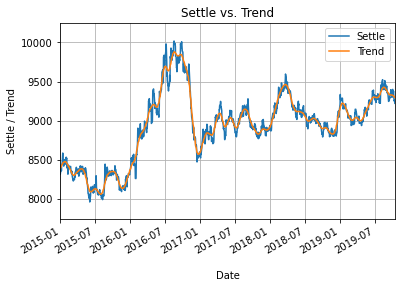

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present

yen_futures_settle_all_df[['Settle','Trend']].plot(
    xlabel = "\nDate", 
    ylabel = "Settle / Trend", 
    xlim = ["2015-01-01", "2019-10-15"],
    ylim = (7750, 10250),
    legend = True,
    grid =True,
    title = "Settle vs. Trend"
)

<AxesSubplot:title={'center':'Noise'}, xlabel='\nDate', ylabel='Noise'>

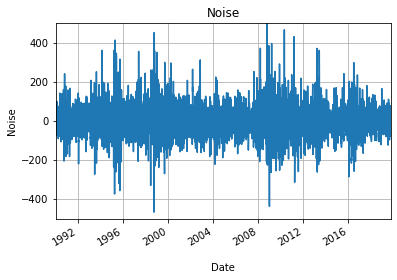

In [8]:
# Plot the Settle Noise
yen_futures_settle_all_df[['Noise']].plot(
    xlabel = "\nDate", 
    ylabel = "Noise", 
    xlim = ["1990-01-02", "2019-10-15"],
    ylim = (-500, 500),
    legend = False,
    grid = True, 
    title = "Noise"
)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [26]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = yen_futures[["Settle"]].pct_change() * 100
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [10]:
import statsmodels.api as sm

# Import the ARMA model
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# Creating the ARMA model using the return values and the order
# For the order parameter, the first 1 indicates the number of AR lags
# For the order parameter, the second 1 indicates the number of MA lags
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\indra\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 04 Aug 2021   AIC                          15798.142
Time:                        01:07:27   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3352           +0.0000j            3.3352            0.5000
AR.2         -157.2096           +0.0000j          157.2096            0.5000
MA.1           -3.3941           +0.0000j            3.3941            0.5000
-----------------------------------------------------------------------------
"""

#### Comment on the ARMA fit: 
All of the p values are significantly larger that 0.05. Therefore within the 95% confidence level this fit is a not a good fit. Thus the projected ARMA forecast is also not as good as expected with in the 95% confidence level.  

<AxesSubplot:title={'center':'5 Day Returns Forecast'}, xlabel='\nDate', ylabel='Noise'>

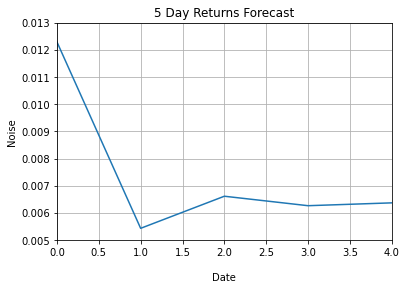

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(
    xlabel = "\nDate", 
    ylabel = "Noise", 
    xlim = [0.0, 4.0],
    ylim = (0.005, 0.013),
    legend = False,
    grid = True, 
    title="5 Day Returns Forecast"
)

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(yen_futures_settle_all_df['Settle'], order=(5, 1, 1))

# Fit the model
results = model.fit()

C:\Users\indra\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\indra\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has n

In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 04 Aug 2021   AIC                          83905.238
Time:                        01:07:29   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.403      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3787j            2.3408           -0.1002
AR.2            1.8917           +1.3787j            2.3408            0.1002
AR.3           -2.2698           -3.0207j            3.7785           -0.3526
AR.4           -2.2698           +3.0207j            3.7785            0.3526
AR.5          -11.0610           -0.0000j           11.0610           -0.5000
MA.1            3.3652           +0.0000j            3.3652            0.0000
-----------------------------------------------------------------------------
"""

#### Comment on the ARIMA fit: 
All of the p values are significantly larger than 0.05. Therefore within the 95% confidence level this fit is a not a good fit. Thus the projected ARIMA forecast is also not as good as expected with in the 95% confidence level.

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}, xlabel='\nDate', ylabel='Price'>

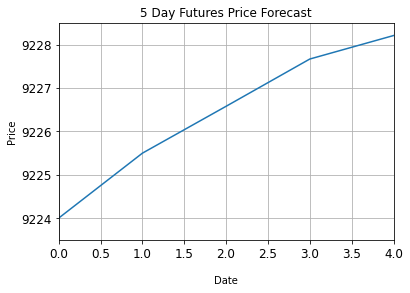

In [15]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(
    fontsize = 12,
    xlabel = "\nDate",
    ylabel = "Price", 
    xlim = [0.0, 4.0],
    ylim = (9223.5, 9228.5),
    legend = False,
    grid = True, 
    title="5 Day Futures Price Forecast"
)

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [17]:
import arch as arch
from arch import arch_model

In [18]:
# Estimate a GARCH model:
# 'p' and 'q'  are akin to the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' means that we're using a GARCH model.
# The 'mean="Zero"' means that we're estimating a GARCH.
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the GARCH Model
results = model.fit(disp="off")


In [19]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Wed, Aug 04 2021   Df Residuals:                     7514
Time:                        01:07:33   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

#### Comment on the GARCH fit: 
Except one (alpha[2]) ALL of the p values are smaller than 0.05. Therefore within 95% confidence level this fit is a relatively better than than the ARMA and ARIMA fits to the data set. Thus the projected GARCH (Genereralized Auto Regressive Conditional Heteroskedasticity) forecast is marginally better than what was obtained under ARMA and ARMIA forcasts with in the 95% confidence level.

In [20]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [21]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# Take the last day of the data we used above. 
# If forecast horizon is 5, then the resulting 'h.1', 'h.2', 'h.3', 'h.4', and 'h.5' 
# are the forecasts for the following 5 days.
forecasts = results.forecast(start='2019-10-15', horizon = forecast_horizon)
forecasts

C:\Users\indra\anaconda3\envs\mlenv\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [22]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [23]:
# Transpose the forecast so that it is easier to plot
# Each row represents the forecast of volatility for the following days.
# Transposing makes the forecast easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}, xlabel='\nDate', ylabel='Annualized Returns'>

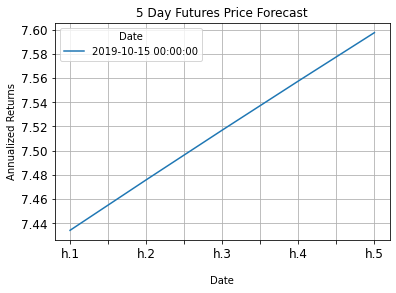

In [24]:
# Plot the final forecast
pd.DataFrame(final).plot(
    fontsize = 12,
    xlabel = "\nDate",
    ylabel = "Annualized Returns", 
    legend = True,
    grid = True, 
    title="5 Day Futures Price Forecast"
)

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

* It is not prudent to buy yen now as per dollar yen amount is projected to go up. This means yen will be cheaper (can buy more yen per doller in the future) in the forecast. However if this firm is selling goods in Japan and is supposed to get paid in Yen in the future it is best to buy a futures contract under current terms so when Yen devalues against dollar the firm can get dollar amount under current terms. That is it can hedge against loosing its revenue due to the weakening of the Yen agaist the dollar. 

Is the risk of the yen expected to increase or decrease?

* ARMA model predicts risk to decrease in the 5-day forecast while the ARIMA and GARCH (the best possible fit from the statistical parameters) predict increased volatility. Since the data is non-stationary ARIMA and GARCH are better models. However the the futures settle values are are somewhat converted to stationary by calculating returns when put into ARMA. From the parameters (p values, AIC = Akaike Information Criterion, BIC = Bayesian Information Criterion, HQIC = Hannan-Quinn Information Criterion) having the lowest value, the best fit is the GARCH. Thus it is possible to consider that the risk to increase as the forecast days increase.   

Based on the model evaluation, would you feel confident in using these models for trading?

* p values of the models to fall within the 95% confidence level must be at or below 0.05 while the AIC, BIC and HQIC must be low relative to p, q, and d values giving different iterations of those models. These models particulalry ARMA and ARIMA needs to be recalibrated with p, q, and d (for ARIMA only) to get better fits. As they stand it is hard to depend on the forecast values from ARMA and ARIMA. Considering the p values: the best p values are for GARCH while the worst p values are for ARIMA. Considering the AIC and BIC the lowest values are for GARCH model and this reinforces that the Garch model is comparatively the best model. However, GARCH modelals has Alpha[2] = 1.000 which is significantly higher than 0.05. In summary, of the three models best is the GARCH while it is still adivisable to vary p and q (as opposed p=2 and q=1) to see if it is possible to make it better. For the ARMA and ARIMA a survey of p, q, and d are a must to get the p, AIC, BIC and HQIC to more acceptable values.    